## Import Libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
import pandas as pd
import requests
import glob

## Basic Information about the dataset

Upload the dataset, then use .head() and .info() to gain a general understanding of what's included. 

In [2]:
## upload the dataset
county_data = pd.read_excel("../data/indicators.xlsx")

In [3]:
## take a look at the first 10 rows, including the header
county_data.head(10)

,county,party_dem_2008,party_dem_2012,party_dem_2016,party_dem_2020,party_dem_2024,party_rep_2008,party_rep_2012,party_rep_2016,party_rep_2020,...,mixed_race_2020,population_2024,male_2024,female_2024,older_adults_2024,hispanic_2024,white_2024,black_2024,asian_2024,mixed_race_2024
0,atlantic,52126,50591,56878,72772,69648,42076,41745,44357,54398,...,8234,274339,133897,140442,51456,54178,150753,35485,21120,11210
1,bergen,171379,170109,201413,258794,256911,111872,111696,123563,145805,...,18237,953243,467592,485651,167276,205545,509075,50172,157669,23583
2,burlington,91746,94214,110786,136381,143277,65518,67668,75120,87934,...,15514,461853,228468,233385,81197,41114,299166,73251,24967,20108
3,camden,139147,141099,154353,185839,182680,43669,44438,49000,61164,...,11346,522581,253604,268977,83495,94913,284011,94675,30724,14701
4,cape may,14405,13798,15661,18930,18501,27638,27402,28107,31740,...,2182,95456,46347,49109,26529,7960,80479,3376,764,2606
5,cumberland,25684,15427,28023,33770,31910,15472,25500,16689,21424,...,3751,153588,78755,74833,23937,49802,67762,27133,2194,4582
6,essex,209583,219383,259419,294191,302750,45790,45453,49843,56504,...,17070,853374,414982,438392,117405,204966,242992,312788,48235,30510
7,gloucester,71782,69900,77790,89628,83702,35397,37239,42898,55460,...,6769,302621,148499,154122,48955,21577,230995,30333,9724,8543
8,hudson,173890,169160,185409,227028,222270,27230,26972,30471,41780,...,14402,712029,356520,355509,86664,302289,197105,74216,112065,19885
9,hunterdon,17712,17678,21530,28485,31204,32935,34810,37562,41056,...,1830,129099,63792,65307,25330,9396,107167,3067,5716,3093


In [4]:
## look at other information related to the dataset
county_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Columns: 106 entries, county to mixed_race_2024
dtypes: float64(5), int64(100), object(1)
memory usage: 17.5+ KB


## Clustering preparation

Before clustering the data, some of the indicators need to be transformed into rates. Those include:
- political-party affiliation
- foreign-born population
- black, asian and hispanic populations
- college-educated population

We also need to normalize some columns so that they're also read as rates. Otherwise, the K-means analysis won't work (data needs to be read on a scale of 0-1). Those include:
- unemployment rate
- median income

In [5]:
## republican percentages
county_data["pct_rep_08"] = county_data["party_rep_2008"]/(county_data["party_rep_2008"] + county_data["party_dem_2008"] + county_data["party_none_2008"])
county_data["pct_rep_12"] = county_data["party_rep_2012"]/(county_data["party_rep_2012"] + county_data["party_dem_2012"] + county_data["party_none_2012"])
county_data["pct_rep_16"] = county_data["party_rep_2016"]/(county_data["party_rep_2016"] + county_data["party_dem_2016"] + county_data["party_none_2016"])
county_data["pct_rep_20"] = county_data["party_rep_2020"]/(county_data["party_rep_2020"] + county_data["party_dem_2020"] + county_data["party_none_2020"])
county_data["pct_rep_24"] = county_data["party_rep_2024"]/(county_data["party_rep_2024"] + county_data["party_dem_2024"] + county_data["party_none_2024"])

In [6]:
## democrat percentages
county_data["pct_dem_08"] = county_data["party_dem_2008"]/(county_data["party_rep_2008"] + county_data["party_dem_2008"] + county_data["party_none_2008"])
county_data["pct_dem_12"] = county_data["party_dem_2012"]/(county_data["party_rep_2012"] + county_data["party_dem_2012"] + county_data["party_none_2012"])
county_data["pct_dem_16"] = county_data["party_dem_2016"]/(county_data["party_rep_2016"] + county_data["party_dem_2016"] + county_data["party_none_2016"])
county_data["pct_dem_20"] = county_data["party_dem_2020"]/(county_data["party_rep_2020"] + county_data["party_dem_2020"] + county_data["party_none_2020"])
county_data["pct_dem_24"] = county_data["party_dem_2024"]/(county_data["party_rep_2024"] + county_data["party_dem_2024"] + county_data["party_none_2024"])

In [7]:
## unaffiliated percentages
county_data["pct_none_08"] = county_data["party_none_2008"]/(county_data["party_rep_2008"] + county_data["party_dem_2008"] + county_data["party_none_2008"])
county_data["pct_none_12"] = county_data["party_none_2012"]/(county_data["party_rep_2012"] + county_data["party_dem_2012"] + county_data["party_none_2012"])
county_data["pct_none_16"] = county_data["party_none_2016"]/(county_data["party_rep_2016"] + county_data["party_dem_2016"] + county_data["party_none_2016"])
county_data["pct_none_20"] = county_data["party_none_2020"]/(county_data["party_rep_2020"] + county_data["party_dem_2020"] + county_data["party_none_2020"])
county_data["pct_none_24"] = county_data["party_none_2024"]/(county_data["party_rep_2024"] + county_data["party_dem_2024"] + county_data["party_none_2024"])

In [8]:
## foreign-born population percentages
county_data["pct_foreign_born_08"] = county_data["foreign_born_2008"]/county_data["population_2008"]
county_data["pct_foreign_born_12"] = county_data["foreign_born_2012"]/county_data["population_2012"]
county_data["pct_foreign_born_16"] = county_data["foreign_born_2016"]/county_data["population_2016"]
county_data["pct_foreign_born_20"] = county_data["foreign_born_2020"]/county_data["population_2020"]
county_data["pct_foreign_born_24"] = county_data["foreign_born_2024"]/county_data["population_2024"]

In [9]:
## black population percentages
county_data["pct_black_08"] = county_data["black_2008"]/(county_data["population_2008"])
county_data["pct_black_12"] = county_data["black_2012"]/(county_data["population_2012"])
county_data["pct_black_16"] = county_data["black_2016"]/(county_data["population_2016"])
county_data["pct_black_20"] = county_data["black_2020"]/(county_data["population_2020"])
county_data["pct_black_24"] = county_data["black_2024"]/(county_data["population_2024"])

In [10]:
## asian population
county_data["pct_asian_08"] = county_data["asian_2008"]/(county_data["population_2008"])
county_data["pct_asian_12"] = county_data["asian_2012"]/(county_data["population_2012"])
county_data["pct_asian_16"] = county_data["asian_2016"]/(county_data["population_2016"])
county_data["pct_asian_20"] = county_data["asian_2020"]/(county_data["population_2020"])
county_data["pct_asian_24"] = county_data["asian_2024"]/(county_data["population_2024"])

In [11]:
## hispanic population
county_data["pct_hispanic_08"] = county_data["hispanic_2008"]/(county_data["population_2008"])
county_data["pct_hispanic_12"] = county_data["hispanic_2012"]/(county_data["population_2012"])
county_data["pct_hispanic_16"] = county_data["hispanic_2016"]/(county_data["population_2016"])
county_data["pct_hispanic_20"] = county_data["hispanic_2020"]/(county_data["population_2020"])
county_data["pct_hispanic_24"] = county_data["hispanic_2024"]/(county_data["population_2024"])

In [12]:
## college-educated population
county_data["pct_college_08"] = county_data["college_degree_2008"]/(county_data["population_2008"])
county_data["pct_college_12"] = county_data["college_degree_2012"]/(county_data["population_2012"])
county_data["pct_college_16"] = county_data["college_degree_2016"]/(county_data["population_2016"])
county_data["pct_college_20"] = county_data["college_degree_2020"]/(county_data["population_2020"])
county_data["pct_college_24"] = county_data["college_degree_2024"]/(county_data["population_2024"])

In [13]:
## normalizing unemployment rates
county_data["unemployed_08"] = county_data["unemployed_rate_2008"]/100
county_data["unemployed_12"] = county_data["unemployed_rate_2012"]/100
county_data["unemployed_16"] = county_data["unemployed_rate_2016"]/100
county_data["unemployed_20"] = county_data["unemployed_rate_2020"]/100
county_data["unemployed_24"] = county_data["unemployed_rate_2024"]/100

In [14]:
## normalizing median income
county_data["income_08"] = county_data["median_income_2008"]/county_data["median_income_2008"].max()
county_data["income_12"] = county_data["median_income_2012"]/county_data["median_income_2012"].max()
county_data["income_16"] = county_data["median_income_2016"]/county_data["median_income_2016"].max()
county_data["income_20"] = county_data["median_income_2020"]/county_data["median_income_2020"].max()
county_data["income_24"] = county_data["median_income_2024"]/county_data["median_income_2024"].max()

## Mapping

Merge the above dataset with a geojson file of new jersey counties.

In [15]:
## read in county shapefiles
counties = gpd.read_file("../data/counties")

/Users/miahollie/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: ../data/counties/NJ_Counties_3424.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [16]:
## check for the correct CRS
counties.crs

<Projected CRS: EPSG:3424>
Name: NAD83 / New Jersey (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New Jersey - counties of Atlantic; Bergen; Burlington; Camden; Cape May; Cumberland; Essex; Gloucester; Hudson; Hunterdon; Mercer; Middlesex; Monmouth; Morris; Ocean; Passaic; Salem; Somerset; Sussex; Union; Warren.
- bounds: (-75.6, 38.87, -73.88, 41.36)
Coordinate Operation:
- name: SPCS83 New Jersey zone (US survey foot)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
## just checking to make sure it's a geodataframe
print(type(counties))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [18]:
## changing county names to lower case so that we can join this file with the original dataset
counties["COUNTY"] = counties["COUNTY"].str.lower()

In [19]:
## join both datasets
combined = pd.merge(
    county_data,
    counties,
    left_on = "county",
    right_on = "COUNTY"
)

In [20]:
## check the dataframe type again
## we'll need to change it into a geodataframe
print(type(combined))

<class 'pandas.core.frame.DataFrame'>


In [21]:
## turn into GeoDataFrame
combined_geo = gpd.GeoDataFrame(
    combined,
    geometry= combined.geometry,
    crs="EPSG:3424")

In [22]:
## checking the dataframe type again
print(type(combined_geo))

<class 'geopandas.geodataframe.GeoDataFrame'>


## Kmeans analysis

The following analysis seeks to answer the following questions: how do NJ counties relate to each other? How have those relations changed over time? 

We can do a K-means analysis to group the state's 23 counties according to the various indicators we've collected. We can do this by performing a K-means analysis for each election year. 

By the end of the analysis, we'll have grouping that can be compared to elections results data. 

### 2008

In [23]:
## identify the indicators we want to analyze
features_2008 = [
    'pct_college_08',
    'pct_hispanic_08',
    'pct_black_08',
    'pct_asian_08',
    'pct_rep_08',
    'pct_dem_08',
    'pct_none_08',
    'pct_foreign_born_08',
    'unemployed_08',
    'income_08'
]

In [24]:
## create an empty array to write the kmeans to
inertias = []

In [25]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2008]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

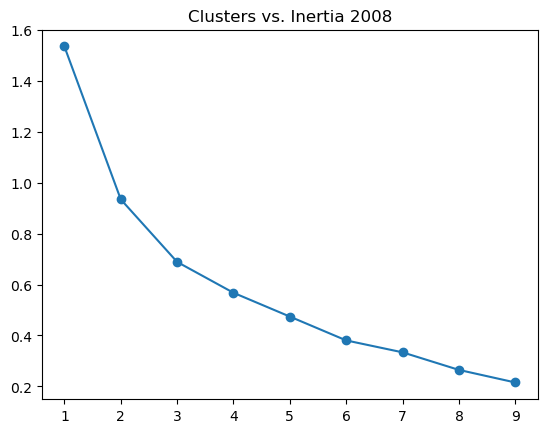

In [26]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2008')
plt.show()

In [27]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2008]) # <-- fit the model to the '08 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [28]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_08'] = kmeans.labels_

In [29]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_08'].value_counts()

kmeans_label_08
1    6
0    4
4    4
5    3
3    3
2    1
Name: count, dtype: int64

<Axes: >

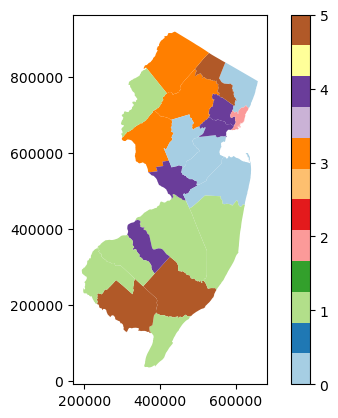

In [30]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_08",
    cmap = "Paired",
    legend = True)

In [31]:
## find the average kmeans of all counties in each category
cluster_feature_averages_08 = combined_geo.groupby('kmeans_label_08')[features_2008].mean().T
cluster_feature_averages_08

kmeans_label_08,0,1,2,3,4,5
pct_college_08,0.176138,0.122134,0.154743,0.177823,0.127344,0.094783
pct_hispanic_08,0.134621,0.060584,0.418718,0.072506,0.182036,0.256870
pct_black_08,0.073547,0.082984,0.117334,0.023462,0.245681,0.151718
pct_asian_08,0.132085,0.020329,0.127573,0.045195,0.055971,0.045391
pct_rep_08,0.202284,0.272015,0.079169,0.367481,0.131612,0.196522
pct_dem_08,0.300691,0.274888,0.505572,0.197151,0.417077,0.295107
pct_none_08,0.497025,0.453097,0.415259,0.435368,0.451311,0.508372
pct_foreign_born_08,0.231776,0.063494,0.406137,0.110779,0.205541,0.176916
unemployed_08,0.045250,0.058167,0.062000,0.041667,0.056500,0.071000
income_08,0.839344,0.649698,0.547386,0.926969,0.629107,0.529349


In [32]:
## find how much each of the groupings averages vary according to individual kmeans averages
cluster_feature_averages_08['variance'] = cluster_feature_averages_08.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_08.sort_values('variance', ascending = False)

kmeans_label_08,0,1,2,3,4,5,variance
income_08,0.839344,0.649698,0.547386,0.926969,0.629107,0.529349,0.025977
pct_hispanic_08,0.134621,0.060584,0.418718,0.072506,0.182036,0.256870,0.018086
pct_foreign_born_08,0.231776,0.063494,0.406137,0.110779,0.205541,0.176916,0.014131
pct_dem_08,0.300691,0.274888,0.505572,0.197151,0.417077,0.295107,0.012231
pct_rep_08,0.202284,0.272015,0.079169,0.367481,0.131612,0.196522,0.010426
pct_black_08,0.073547,0.082984,0.117334,0.023462,0.245681,0.151718,0.005910
pct_asian_08,0.132085,0.020329,0.127573,0.045195,0.055971,0.045391,0.002209
pct_none_08,0.497025,0.453097,0.415259,0.435368,0.451311,0.508372,0.001288
pct_college_08,0.176138,0.122134,0.154743,0.177823,0.127344,0.094783,0.001090
unemployed_08,0.045250,0.058167,0.062000,0.041667,0.056500,0.071000,0.000117


### 2012

In [33]:
## identify the indicators we want to analyze
features_2012 = [
    'pct_college_12',
    'pct_hispanic_12',
    'pct_black_12',
    'pct_asian_12',
    'pct_rep_12',
    'pct_dem_12',
    'pct_none_12',
    'pct_foreign_born_12',
    'unemployed_12',
    'income_12'
]

In [34]:
## create an empty array to write the kmeans to
inertias = []

In [35]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2012]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

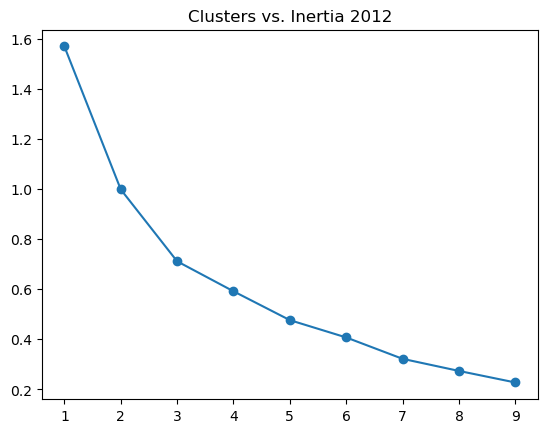

In [36]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2012')
plt.show()

In [37]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2012]) # <-- fit the model to the '12 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [38]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_12'] = kmeans.labels_

In [39]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_12'].value_counts()

kmeans_label_12
2    4
5    4
1    4
0    4
4    3
3    2
Name: count, dtype: int64

<Axes: >

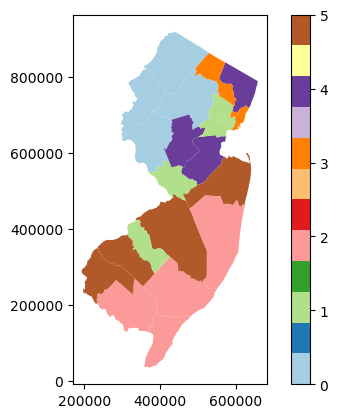

In [40]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_12",
    cmap = "Paired",
    legend = True)

In [41]:
cluster_feature_averages_12 = combined_geo.groupby('kmeans_label_12')[features_2012].mean().T
cluster_feature_averages_12

kmeans_label_12,0,1,2,3,4,5
pct_college_12,0.169595,0.128664,0.106137,0.136012,0.183969,0.135588
pct_hispanic_12,0.076068,0.192800,0.145530,0.396493,0.158398,0.069331
pct_black_12,0.027168,0.243999,0.103250,0.112840,0.074874,0.115652
pct_asian_12,0.041205,0.058085,0.028660,0.092332,0.168268,0.032615
pct_rep_12,0.369188,0.127304,0.298525,0.128744,0.192794,0.214393
pct_dem_12,0.194847,0.408742,0.213876,0.410850,0.307504,0.303575
pct_none_12,0.435965,0.463954,0.487600,0.460406,0.499702,0.482031
pct_foreign_born_12,0.107479,0.210358,0.097970,0.341135,0.274634,0.079224
unemployed_12,0.079500,0.098500,0.130500,0.100000,0.079667,0.099000
income_12,0.855738,0.614972,0.527713,0.549027,0.825677,0.701799


In [42]:
## how do the various clusters vary across each row?
cluster_feature_averages_12['variance'] = cluster_feature_averages_12.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_12.sort_values('variance', ascending = False)

kmeans_label_12,0,1,2,3,4,5,variance
income_12,0.855738,0.614972,0.527713,0.549027,0.825677,0.701799,0.019430
pct_hispanic_12,0.076068,0.192800,0.145530,0.396493,0.158398,0.069331,0.014290
pct_foreign_born_12,0.107479,0.210358,0.097970,0.341135,0.274634,0.079224,0.011566
pct_rep_12,0.369188,0.127304,0.298525,0.128744,0.192794,0.214393,0.009219
pct_dem_12,0.194847,0.408742,0.213876,0.410850,0.307504,0.303575,0.008480
pct_black_12,0.027168,0.243999,0.103250,0.112840,0.074874,0.115652,0.005217
pct_asian_12,0.041205,0.058085,0.028660,0.092332,0.168268,0.032615,0.002847
pct_college_12,0.169595,0.128664,0.106137,0.136012,0.183969,0.135588,0.000811
pct_none_12,0.435965,0.463954,0.487600,0.460406,0.499702,0.482031,0.000522
unemployed_12,0.079500,0.098500,0.130500,0.100000,0.079667,0.099000,0.000348


### 2016

In [43]:
## identify the indicators we want to analyze
features_2016 = [
    'pct_college_16',
    'pct_hispanic_16',
    'pct_black_16',
    'pct_asian_16',
    'pct_rep_16',
    'pct_dem_16',
    'pct_none_16',
    'pct_foreign_born_16',
    'unemployed_16',
    'income_16'
]

In [44]:
## create an empty array to write the kmeans to
inertias = []

In [45]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2016]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

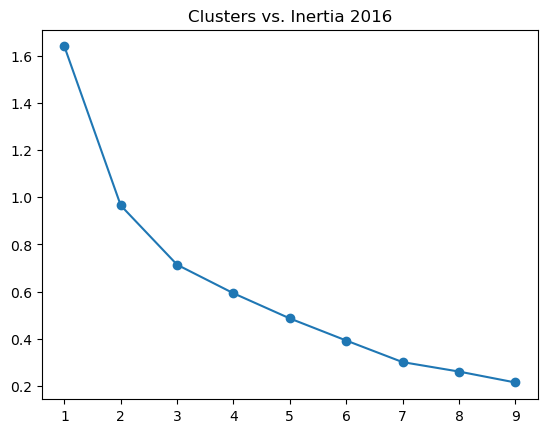

In [46]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2016')
plt.show()

In [47]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2016]) # <-- fit the model to the '12 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [48]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_16'] = kmeans.labels_

In [49]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_16'].value_counts()

kmeans_label_16
1    5
4    4
3    4
0    3
5    3
2    2
Name: count, dtype: int64

<Axes: >

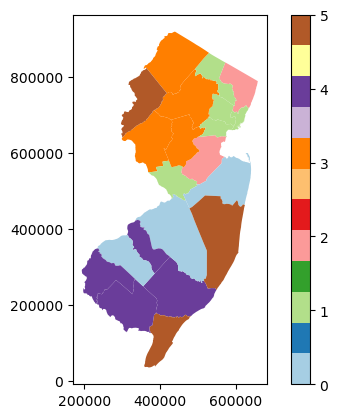

In [50]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_16",
    cmap = "Paired",
    legend = True)

In [51]:
cluster_feature_averages_16 = combined_geo.groupby('kmeans_label_16')[features_2016].mean().T
cluster_feature_averages_16

kmeans_label_16,0,1,2,3,4,5
pct_college_16,0.161198,0.139287,0.188667,0.195835,0.104834,0.139039
pct_hispanic_16,0.078095,0.302854,0.191859,0.100175,0.177534,0.080694
pct_black_16,0.107604,0.201173,0.072758,0.040719,0.160231,0.038236
pct_asian_16,0.043296,0.079943,0.196326,0.079614,0.039953,0.019129
pct_rep_16,0.234529,0.132739,0.174091,0.350426,0.202319,0.361897
pct_dem_16,0.331219,0.449614,0.366168,0.240148,0.345829,0.218581
pct_none_16,0.434252,0.417647,0.459741,0.409426,0.451852,0.419522
pct_foreign_born_16,0.093678,0.295459,0.312149,0.149066,0.107582,0.075423
unemployed_16,0.046000,0.052200,0.042500,0.040750,0.066500,0.065000
income_16,0.757780,0.595062,0.782066,0.926186,0.530062,0.602238


In [52]:
## how do the various clusters vary across each row?
cluster_feature_averages_16['variance'] = cluster_feature_averages_16.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_16.sort_values('variance', ascending = False)

kmeans_label_16,0,1,2,3,4,5,variance
income_16,0.757780,0.595062,0.782066,0.926186,0.530062,0.602238,0.022135
pct_foreign_born_16,0.093678,0.295459,0.312149,0.149066,0.107582,0.075423,0.011004
pct_rep_16,0.234529,0.132739,0.174091,0.350426,0.202319,0.361897,0.008862
pct_hispanic_16,0.078095,0.302854,0.191859,0.100175,0.177534,0.080694,0.007634
pct_dem_16,0.331219,0.449614,0.366168,0.240148,0.345829,0.218581,0.007244
pct_black_16,0.107604,0.201173,0.072758,0.040719,0.160231,0.038236,0.004384
pct_asian_16,0.043296,0.079943,0.196326,0.079614,0.039953,0.019129,0.004022
pct_college_16,0.161198,0.139287,0.188667,0.195835,0.104834,0.139039,0.001171
pct_none_16,0.434252,0.417647,0.459741,0.409426,0.451852,0.419522,0.000408
unemployed_16,0.046000,0.052200,0.042500,0.040750,0.066500,0.065000,0.000126


### 2020

In [53]:
## identify the indicators we want to analyze
features_2020 = [
    'pct_college_20',
    'pct_hispanic_20',
    'pct_black_20',
    'pct_asian_20',
    'pct_rep_20',
    'pct_dem_20',
    'pct_none_20',
    'pct_foreign_born_20',
    'unemployed_20',
    'income_20'
]

In [54]:
## create an empty array to write the kmeans to
inertias = []

In [55]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2020]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

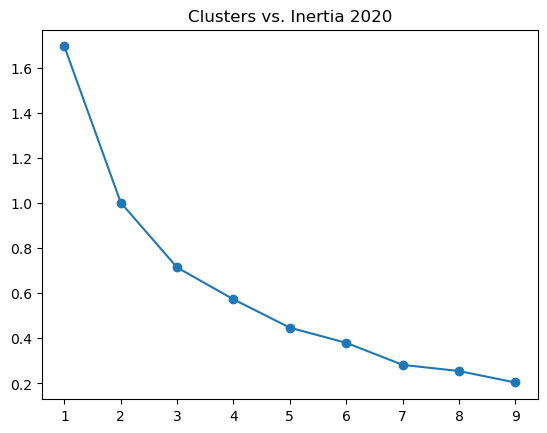

In [56]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2020')
plt.show()

In [57]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2020]) # <-- fit the model to the '12 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [58]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_20'] = kmeans.labels_

In [59]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_20'].value_counts()

kmeans_label_20
3    5
4    4
1    4
2    3
5    3
0    2
Name: count, dtype: int64

<Axes: >

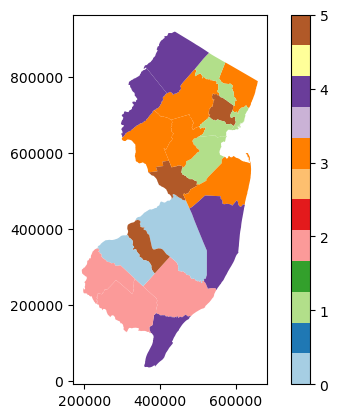

In [60]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_20",
    cmap = "Paired",
    legend = True)

In [61]:
cluster_feature_averages_20 = combined_geo.groupby('kmeans_label_20')[features_2020].mean().T
cluster_feature_averages_20

kmeans_label_20,0,1,2,3,4,5
pct_college_20,0.166560,0.163975,0.102418,0.218052,0.161560,0.145772
pct_hispanic_20,0.074177,0.344294,0.199658,0.132445,0.089020,0.194790
pct_black_20,0.130573,0.126114,0.151719,0.053640,0.033249,0.252913
pct_asian_20,0.040875,0.126055,0.033443,0.109298,0.017742,0.075615
pct_rep_20,0.249502,0.156026,0.258172,0.298917,0.398975,0.137578
pct_dem_20,0.394878,0.471411,0.345350,0.317822,0.240838,0.483669
pct_none_20,0.355620,0.372563,0.396478,0.383261,0.360187,0.378753
pct_foreign_born_20,0.077561,0.346795,0.099000,0.199787,0.073564,0.206201
unemployed_20,0.084000,0.100750,0.122333,0.079200,0.100000,0.093667
income_20,0.761022,0.685144,0.519334,0.949977,0.688929,0.617189


In [62]:
## how do the various clusters vary across each row?
cluster_feature_averages_20['variance'] = cluster_feature_averages_20.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_20.sort_values('variance', ascending = False)

kmeans_label_20,0,1,2,3,4,5,variance
income_20,0.761022,0.685144,0.519334,0.949977,0.688929,0.617189,0.021195
pct_foreign_born_20,0.077561,0.346795,0.099000,0.199787,0.073564,0.206201,0.011258
pct_hispanic_20,0.074177,0.344294,0.199658,0.132445,0.089020,0.194790,0.009798
pct_rep_20,0.249502,0.156026,0.258172,0.298917,0.398975,0.137578,0.009225
pct_dem_20,0.394878,0.471411,0.345350,0.317822,0.240838,0.483669,0.008729
pct_black_20,0.130573,0.126114,0.151719,0.053640,0.033249,0.252913,0.006124
pct_asian_20,0.040875,0.126055,0.033443,0.109298,0.017742,0.075615,0.001917
pct_college_20,0.166560,0.163975,0.102418,0.218052,0.161560,0.145772,0.001390
unemployed_20,0.084000,0.100750,0.122333,0.079200,0.100000,0.093667,0.000232
pct_none_20,0.355620,0.372563,0.396478,0.383261,0.360187,0.378753,0.000229


### 2024

In [63]:
## identify the indicators we want to analyze
features_2024 = [
    'pct_college_24',
    'pct_hispanic_24',
    'pct_black_24',
    'pct_asian_24',
    'pct_rep_24',
    'pct_dem_24',
    'pct_none_24',
    'pct_foreign_born_24',
    'unemployed_24',
    'income_24'
]

In [64]:
## create an empty array to write the kmeans to
inertias = []

In [65]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2024]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

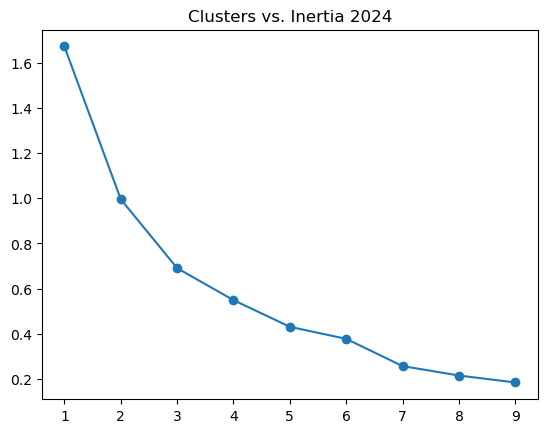

In [66]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2024')
plt.show()

In [67]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2024]) # <-- fit the model to the '12 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [68]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_24'] = kmeans.labels_

In [69]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_24'].value_counts()

kmeans_label_24
1    6
2    4
4    3
0    3
5    3
3    2
Name: count, dtype: int64

<Axes: >

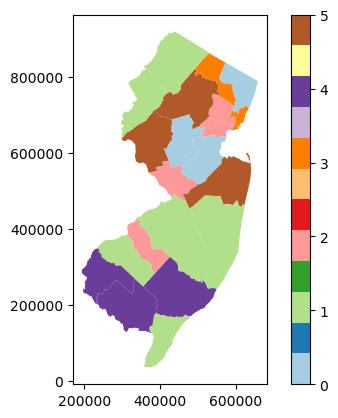

In [70]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_24",
    cmap = "Paired",
    legend = True)

In [71]:
## what do the clusters look like? 
cluster_feature_averages_24 = combined_geo.groupby('kmeans_label_24')[features_2024].mean().T
cluster_feature_averages_24

kmeans_label_24,0,1,2,3,4,5
pct_college_24,0.206332,0.170013,0.151963,0.166274,0.107212,0.227702
pct_hispanic_24,0.197747,0.091566,0.236168,0.428139,0.208348,0.108852
pct_black_24,0.079760,0.065607,0.234246,0.102380,0.147294,0.038841
pct_asian_24,0.201281,0.026576,0.072947,0.105562,0.033420,0.068338
pct_rep_24,0.223416,0.374879,0.153767,0.173873,0.291635,0.358890
pct_dem_24,0.380796,0.284335,0.472089,0.459530,0.322186,0.289113
pct_none_24,0.395787,0.340786,0.374144,0.366597,0.386179,0.351998
pct_foreign_born_24,0.307844,0.078313,0.242480,0.375905,0.099753,0.143268
unemployed_24,0.043000,0.050500,0.051500,0.054000,0.064667,0.039667
income_24,0.888333,0.714233,0.643070,0.641481,0.521218,0.955734


In [72]:
## how do the various clusters vary across each row?
cluster_feature_averages_24['variance'] = cluster_feature_averages_24.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_24.sort_values('variance', ascending = False)

kmeans_label_24,0,1,2,3,4,5,variance
income_24,0.888333,0.714233,0.643070,0.641481,0.521218,0.955734,0.027043
pct_hispanic_24,0.197747,0.091566,0.236168,0.428139,0.208348,0.108852,0.014532
pct_foreign_born_24,0.307844,0.078313,0.242480,0.375905,0.099753,0.143268,0.014415
pct_rep_24,0.223416,0.374879,0.153767,0.173873,0.291635,0.358890,0.008795
pct_dem_24,0.380796,0.284335,0.472089,0.459530,0.322186,0.289113,0.006940
pct_black_24,0.079760,0.065607,0.234246,0.102380,0.147294,0.038841,0.004965
pct_asian_24,0.201281,0.026576,0.072947,0.105562,0.033420,0.068338,0.004088
pct_college_24,0.206332,0.170013,0.151963,0.166274,0.107212,0.227702,0.001783
pct_none_24,0.395787,0.340786,0.374144,0.366597,0.386179,0.351998,0.000426
unemployed_24,0.043000,0.050500,0.051500,0.054000,0.064667,0.039667,0.000078
